<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/38_Lite_VAE%2C_CVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Lite

Макс 10 баллов

Используйте готовый ноутбук с занятия.

Сделайте более мощный CVAE, обучите больше эпох до более низкого уровня ошибки и сравните изображения, которые получаются в итоге. Коррелирует ли уровень ошибки с качеством изображений?

Подайте 5 раз в decoder CVAE один и тот же случайный вектор и любой label от 0 до 9 на выбор. Посмотрите, что сгенерирует CVAE.
Пояснение: Автокодировщики работают следующим образом: сначала, энкодер кодирует данные в n-мерное пространство (выход энкодера), и кодированные данные подаются на вход декодера, чтобы сгенерить новую картинку.

Для выполнение данного пункта, нужно провести следующий эксперимент:

1. Обучите автокодировщик

2. Разбейте его на 2 отдельные модели: энкодер и декодер. Далее понадобится только декодер

3. На вход декодера подайте 5 векторов из рандомных чисел и выведите на экран получившиеся изображения

# VAE

In [ ]:
!pip install keras==2.0 -q # загружаем эту версию кераса для корректной работы скрипта
!pip install tensorflow==1.13.2 -q  # загружаем эту версию тензорфлоу  для корректной работы скрипта

     |████████████████████████████████| 191 kB 8.4 MB/s 
     |████████████████████████████████| 458.3 MB 12 kB/s 
     |████████████████████████████████| 462 kB 44.8 MB/s 
     |████████████████████████████████| 458.3 MB 12 kB/s 
     |████████████████████████████████| 458.3 MB 11 kB/s 
     |████████████████████████████████| 454.4 MB 25 kB/s 
     |████████████████████████████████| 1.2 MB 41.8 MB/s 
     |████████████████████████████████| 462 kB 56.3 MB/s 
     |████████████████████████████████| 4.0 MB 37.0 MB/s 
     |████████████████████████████████| 132 kB 55.7 MB/s 
     |████████████████████████████████| 92.7 MB 20 kB/s 
     |████████████████████████████████| 3.2 MB 38.2 MB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 
     |████████████████████████████████| 367 kB 50.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.7 requi

In [ ]:
import sys # модуль содержит параметры и функции, которые относятся к Python и его среде
import numpy as np # загружаем библиотеку для работы с массивами данных
import matplotlib.pyplot as plt # из библиотеки для визуализации данных возьмём интерфейс для построения графиков простых функций
import seaborn as sns # более высокоуровневое API на базе библиотеки matplotlib
from scipy.stats import norm # модуль с нормальными непрерывными случайными величинами
#from keras.datasets import fashion_mnist # загружаем готовую базу mnist(fashion- с одеждой, обувью и т.п)

from tensorflow.keras.datasets import mnist # загружаем готовую стандартную базу рукописных цифр mnist
from tensorflow.keras.optimizers import Adam, RMSprop # загружаем выбранные оптимизаторы
from tensorflow.keras.layers import Input, Dense, LeakyReLU  # загружаем необходимые слои(входной, полносвязный)
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda # загружаем слои(нормализации, регуляризации и т.д)
from tensorflow.keras.models import Model # загружаем абстрактный класс базовой модели сети от кераса
from tensorflow.keras.losses import binary_crossentropy # импортируем функцию потерь

from tensorflow.keras import backend as K # устанавливаем переменную для окружения кераса
from IPython.display import clear_output # импортируем модуль очистки output'а ячейки
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard # импортируем коллбэки
from scipy.stats import multivariate_normal

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() # загружаем данные из базы mnist с разбивкой на train/test
#(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data() # загружаем данные из базы fashion_mnist с разбивкой на train/test

x_train = x_train.astype('float32') / 255. # представляем x_train в виде значений от 0 до 1
x_test  = x_test .astype('float32') / 255. # представляем x_test в виде значений от 0 до 1
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) # меняем форму, приводим к нужным нам размерам
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1)) # меняем форму, приводим к нужным нам размерам

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
batch_size = 100 # размер батча
latent_dim = 10  # размер скрытого слоя/пространства
dropout_rate = 0.3 # размер слоя регуляризации, "выключим" указанное количество нейронов, во избежание переобучения
start_lr = 0.0001  # шаг обучения

In [ ]:
def create_vae(): # объявляем функцию создания вариационного автокодировщика
    models = {} # задаем словарь моделей

    # Добавим Dropout и BatchNormalization
    def apply_bn_and_dropout(x): # функция будет принимать на вход слой x
        return Dropout(dropout_rate)(BatchNormalization()(x)) # и применять к нему регуляризацию/нормализацию

    # Энкодер
    input_img = Input(batch_shape=(batch_size, 28, 28, 1)) # размерности батч, строк, столбцов, фильтров одной картинки
    x = Flatten()(input_img) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
    x = Dense(256, activation='relu')(x) # полносвязный слой на 256 нейронов
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(128, activation='relu')(x) # полносвязный слой на 128 нейронов
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации

    # Предсказываем параметры распределений
    # Вместо того, чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации
    
    z_mean = Dense(latent_dim)(x) # скрытое пространство(мат.ожидание) размером 10
    
    z_log_var = Dense(latent_dim)(x) # скрытое пространство(лог.вариации) размером 10

    # Сэмплирование из Q с трюком репараметризации
    def sampling(args): # обьявляем функцию сэмплирования
        z_mean, z_log_var = args # принимаем в аргументах z_mean, z_log_var, раскусываем их
        
        # Керасовским методом делаем нормальное распределение(500 10тимерных), мат.ожидание 0, ст.отклонение 1
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # Задаем самописный слой, к-й принимает лист [z_mean, z_log_var], семплирует, и на выходе выдает размерность (10,)
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    models["encoder"]  = Model(input_img, l) # модель энкодера от входа до лямбда слоя
    
    models["z_meaner"] = Model(input_img, z_mean) # отдельная модель с путем от входа до z_mean
    
    models["z_lvarer"] = Model(input_img, z_log_var) # отдельная модель с путем от входа до z_log_var

    # Декодер
    z = Input(shape=(latent_dim, )) # задаем входную размерность (10,)
    x = Dense(128)(z) # полносвязный слой на 128 нейронов
    x = LeakyReLU()(x) # применяем функцию активации отдельным слоем
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(256)(x) # полносвязный слой на 256 нейронов
    x = LeakyReLU()(x) # применяем функцию активации отдельным слоем
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(28*28, activation='sigmoid')(x) # полносвязный слой на 784 нейрона
    decoded = Reshape((28, 28, 1))(x) # меняем форму, приводим к нужным нам размерам

    models["decoder"] = Model(z, decoded, name='Decoder') # собираем модель декодера
    
    # Cобираем вариационный автокодировщик, также двойное преобразование над входной картинкой(энкодер-декодер)
    models["vae"] = Model(input_img, models["decoder"](models["encoder"](input_img)), name='VAE')

    def vae_loss(x, decoded): # объявляем самописную функцию потерь
        x = K.reshape(x, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) x через керасовскую функцию
        decoded = K.reshape(decoded, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) decoded через керасовскую функцию
        xent_loss = 28*28*binary_crossentropy(x, decoded) # берем бинарную кроссэнтропию между x и decoded, с учетом пикселей
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) # по формуле устанавливаем ошибку kl_loss
        return (xent_loss + kl_loss)/2/28/28 # функция вернет суммарную ошибку с учетом распределения и размеров пикселей

    return models, vae_loss

models, vae_loss = create_vae() # получаем модели и свою функцию потерь
vae = models["vae"] # задаем модель вариационного автокодировщика

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
vae.compile(optimizer=Adam(start_lr), loss=vae_loss) # компилируем модель с выбранным оптимайзером и своей функцией потерь

In [ ]:
digit_size = 28 # задаем размеры цифр

def plot_digits(*args, invert_colors=False): # функция отрисует две линии картинок - оригинальные и выходные из автокодировщика
    args = [x.squeeze() for x in args]  # удаляем оси с одним элементом из аргументов
    n = min([x.shape[0] for x in args]) # берем минимальное от нулевой оси x'ов в аргументах
    figure = np.zeros((digit_size * len(args), digit_size * n)) # создаем фигуру с использованием массива нулей по заданным размерам

    for i in range(n):
        for j in range(len(args)): # заполняем фигуру значениями
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors: # если значение invert_colors будет True
        figure = 1-figure # то фигуру делаем обратной

    plt.figure(figsize=(2*n, 2*len(args))) # плотим фигуру с заданными значениями
    plt.imshow(figure, cmap='Greys_r') # выведем ее на экран в указанных цветах
    plt.grid(False) # указываем, что сетка не нужна
    ax = plt.gca() # получаем текущий объект Axes
    ax.get_xaxis().set_visible(False) # ось координат xaxis делаем невидимой
    ax.get_yaxis().set_visible(False) # ось координат yaxis делаем невидимой
    plt.show() # выводим отрисованное на экран

n = 15 # Картинка с 15x15 цифр
digit_size = 28


In [ ]:
# Массивы, в которые будем сохранять результаты, для последующей визуализации
latent_distrs = []
epochs = []

# Эпохи, в которые будем сохранять
save_epochs = set([i*5 for i in range(0,25)])

# Отслеживать будем на вот этих цифрах
imgs = x_test[:batch_size]
n_compare = 10

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]

# Функция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
    if epoch in save_epochs:
        clear_output() # Не захламляем output

        # Сравнение реальных и декодированных цифр
        decoded = vae.predict(imgs, batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])

        # Сохранение многообразия и распределения z для создания анимации после
        epochs.append(epoch)
        #figs.append(figure)
        latent_distrs.append(encoder_mean.predict(x_test, batch_size))

        
# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)

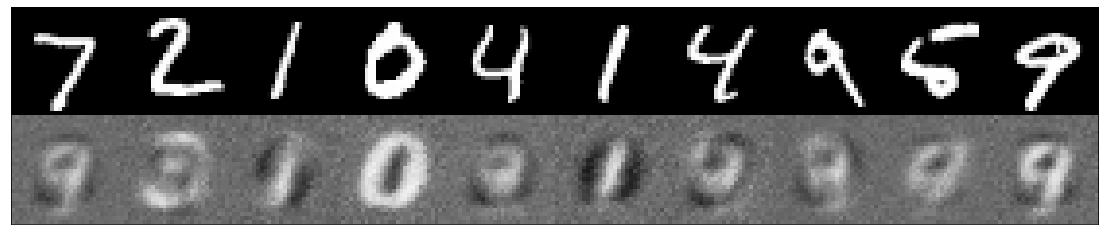

60000/60000 [==============================] - 16s 266us/sample - loss: 0.3468 - val_loss: 0.2522
Epoch 2/5
60000/60000 [==============================] - 11s 191us/sample - loss: 0.1963 - val_loss: 0.1316
Epoch 3/5
60000/60000 [==============================] - 11s 189us/sample - loss: 0.1330 - val_loss: 0.1104
Epoch 4/5
60000/60000 [==============================] - 11s 188us/sample - loss: 0.1182 - val_loss: 0.1027
Epoch 5/5
60000/60000 [==============================] - 12s 195us/sample - loss: 0.1108 - val_loss: 0.0974


In [ ]:
# Запуск обучения 
vae.fit(x_train, x_train, shuffle=True, epochs=5,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[pltfig],
        verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

##Выводим картинки на экран

In [ ]:
def plot_images(generator, examples=10, dim=(10,10), figsize=(15,15)): # функция добавляет шум на скрытом пространстве
    k = 1.1
    noise = np.random.normal(loc=0, scale=1, size=[1, latent_dim]) # создаем шум нормальным распределением
    
    im_arr = [generator.predict((k**i)*noise) for i in range(0,examples)] # получаем сгенеренные выходные картинки над заданным шумом
    im_arr = np.array(im_arr).reshape(examples,28,28) # переводим в numpy массив, подгоняем размеры

    plt.figure(figsize=figsize) # задаем способ отрисовки картинок
    for i in range(im_arr.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(im_arr[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()

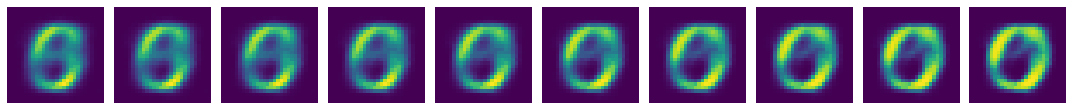

In [ ]:
plot_images(generator) # отрисовываем картинки

In [ ]:
def plot_images_two_points(generator, examples=10, dim=(10,10), figsize=(15,15)):
    
    noise1 = 1*np.random.normal(loc=0, scale=1, size=[1, latent_dim]) # создаем первое случайное зашумленное распределение
    noise2 = 1*np.random.normal(loc=0, scale=1, size=[1, latent_dim]) # создаем второе случайное зашумленное распределение
    
    # получаем сгенеренные выходные картинки плавным переходом от одного зашумленного к другому 
    im_arr = [generator.predict(i*noise2/(examples-1) + (examples-i-1)*noise1/(examples-1)) for i in range(0,examples)]
    im_arr = np.array(im_arr).reshape(examples,28,28) # переводим в numpy массив, подгоняем размеры

    plt.figure(figsize=figsize) # задаем способ отрисовки картинок
    for i in range(im_arr.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(im_arr[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()

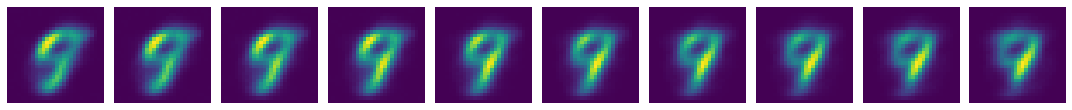

In [ ]:
plot_images_two_points(generator) # отрисовываем картинки

In [ ]:
z_imgs = models['encoder'].predict(x_test[:500], batch_size=batch_size)

In [ ]:
print(z_imgs.shape)

(500, 10)


In [ ]:
def plot_images_two_points2(generator, z_imgs, examples=10, dim=(10,10), figsize=(15,15)):
    
    index1 = int(round(200*np.random.sample(1)[0])) # запишем в первый индекс случайно сгенерированное значение
    index2 = int(round(200*np.random.sample(1)[0])) # запишем во второй индекс случайно сгенерированное значение
    noise1 = z_imgs[index1,:].reshape(1,10) # сгенерируем первую зашумленную картинку по полученному индексу
    noise2 = z_imgs[index2,:].reshape(1,10) # сгенерируем вторую зашумленную картинку по полученному индексу
    
    # получаем сгенеренные выходные картинки плавным переходом от одного зашумленного к другому 
    im_arr = [generator.predict(i*noise2/(examples-1) + (examples-i-1)*noise1/(examples-1)) for i in range(0,examples)]
    im_arr = np.array(im_arr).reshape(examples,28,28) # переводим в numpy массив, подгоняем размеры

    plt.figure(figsize=figsize) # задаем способ отрисовки картинок
    for i in range(im_arr.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(im_arr[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()

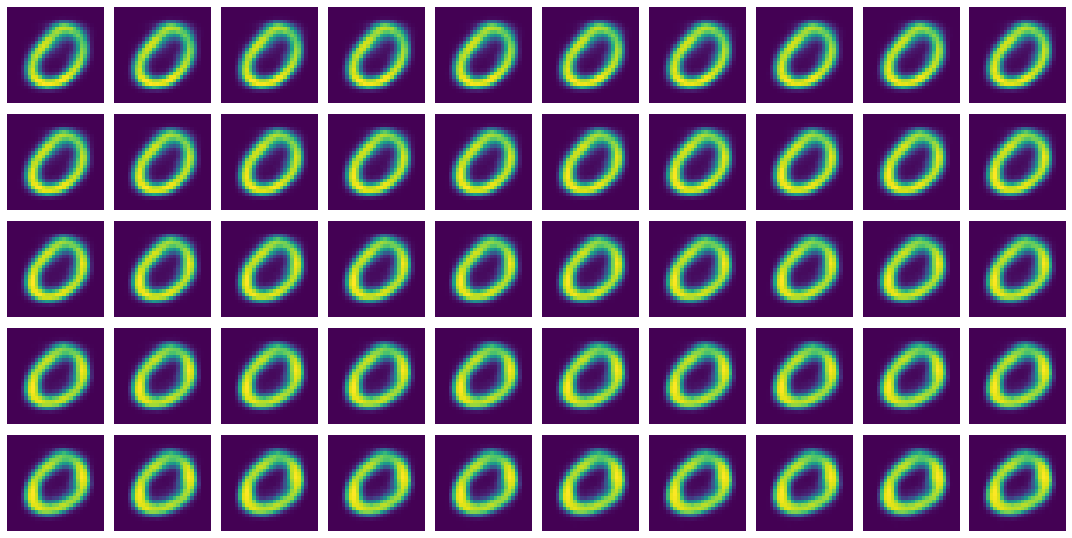

In [ ]:
plot_images_two_points2(generator, z_imgs, examples=50) # отрисовываем картинки

##Визуализируем скрытое пространство

In [ ]:
latent_dim = 2

# Компилируем модель с выбранным оптимайзером и своей функцией потерь
vae.compile(optimizer=Adam(start_lr), loss=vae_loss)

# Запуск обучения 
vae.fit(x_train, x_train, shuffle=True, epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        #callbacks=[pltfig],
        verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 13s 212us/sample - loss: 0.1047 - val_loss: 0.0924
Epoch 2/10
60000/60000 [==============================] - 11s 187us/sample - loss: 0.1008 - val_loss: 0.0896
Epoch 3/10
60000/60000 [==============================] - 11s 187us/sample - loss: 0.0983 - val_loss: 0.0877
Epoch 4/10
60000/60000 [==============================] - 11s 186us/sample - loss: 0.0967 - val_loss: 0.0864
Epoch 5/10
60000/60000 [==============================] - 11s 188us/sample - loss: 0.0956 - val_loss: 0.0855
Epoch 6/10
60000/60000 [==============================] - 11s 187us/sample - loss: 0.0947 - val_loss: 0.0847
Epoch 7/10
60000/60000 [==============================] - 11s 188us/sample - loss: 0.0941 - val_loss: 0.0841
Epoch 8/10
60000/60000 [==============================] - 11s 187us/sample - loss: 0.0935 - val_loss: 0.0836
Epoch 9/10
60000/60000 [==============================] - 11s 188us/sample - l

In [ ]:
encoder_sigma = models["z_lvarer"] # модель для получения логарифма дисперсии
encoder_mean = models["z_meaner"]  # модель для получения среднего
encoder_mean = encoder_mean.predict(x_test[:1000], batch_size)   # получаем значения среднего
encoder_sigma = encoder_sigma.predict(x_test[:1000], batch_size) # получаем значения логарифма дисперсии
encoder_sigma = np.sqrt(np.exp(encoder_sigma)) # достаем из логарифма дисперсии значение отклонения

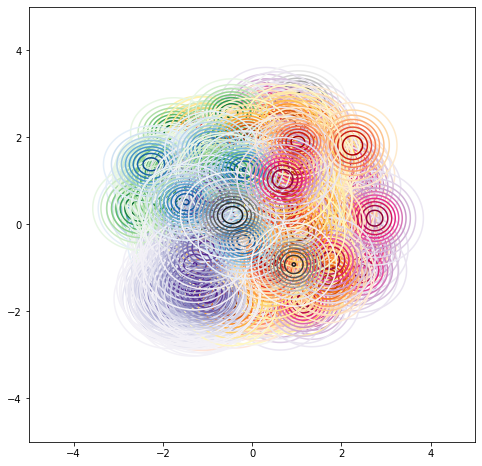

In [ ]:
# Список для раскраски каждого класса разными цветами
colorss = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd']

plt.figure(figsize=(8,8))
for i in range(len(encoder_mean)):
  x = np.linspace(encoder_mean[i][0]-10*encoder_sigma[i][0],encoder_mean[i][0]+10*encoder_sigma[i][0],500)
  y = np.linspace(encoder_mean[i][1]-10*encoder_sigma[i][1],encoder_mean[i][1]+10*encoder_sigma[i][1],500)
  X, Y = np.meshgrid(x,y)
  pos = np.empty(X.shape + (2,))
  pos[:, :, 0] = X; pos[:, :, 1] = Y

  rv = multivariate_normal([encoder_mean[i][0], encoder_mean[i][1]], [[encoder_sigma[i][0], 0], [0, encoder_sigma[i][1]]])
  plt.contour(X, Y, rv.pdf(pos), 10, cmap=colorss[int(y_test[i])])
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

# CVAE


In [ ]:
!pip install keras==2.0 -q # загружаем эту версию кераса для корректной работы скрипта
!pip install tensorflow==1.13.2 -q -q  # загружаем эту версию тензорфлоу  для корректной работы скрипта

     |████████████████████████████████| 191 kB 4.4 MB/s 
     |████████████████████████████████| 497.5 MB 25 kB/s 
     |████████████████████████████████| 495.0 MB 35 kB/s 
     |████████████████████████████████| 463.8 MB 34 kB/s 
     |████████████████████████████████| 458.3 MB 13 kB/s 
     |████████████████████████████████| 458.3 MB 14 kB/s 
     |████████████████████████████████| 462 kB 33.2 MB/s 
     |████████████████████████████████| 132 kB 31.8 MB/s 
     |████████████████████████████████| 458.3 MB 11 kB/s 
     |████████████████████████████████| 460.3 MB 9.3 kB/s 
     |████████████████████████████████| 1.2 MB 49.1 MB/s 
     |████████████████████████████████| 462 kB 49.3 MB/s 
     |████████████████████████████████| 4.0 MB 36.4 MB/s 
     |████████████████████████████████| 92.7 MB 1.3 MB/s 
     |████████████████████████████████| 3.2 MB 32.9 MB/s 
     |████████████████████████████████| 367 kB 54.4 MB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 
ERROR: pip's dep

In [ ]:
import sys # модуль содержит параметры и функции, которые относятся к Python и его среде
import numpy as np # загружаем библиотеку для работы с массивами данных
import matplotlib.pyplot as plt # из библиотеки для визуализации данных возьмём интерфейс для построения графиков простых функций
%matplotlib inline
from scipy.stats import norm # модуль с нормальными непрерывными случайными величинами
# import seaborn as sns

from tensorflow.keras.datasets import mnist # загружаем готовую стандартную базу рукописных цифр mnist
from tensorflow.keras.utils import to_categorical # загружаем утилиты кераса для one-hot кодировки
from tensorflow.keras.layers import Input, Dense # загружаем необходимые слои(входной, полносвязный)
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda # загружаем слои(нормализации, регуляризации и т.д)
from tensorflow.keras.layers import concatenate, LeakyReLU # подгружаем слой конкатенации
from tensorflow.keras.models import Model # загружаем абстрактный класс базовой модели сети от кераса 
from tensorflow.keras.losses import binary_crossentropy # импортируем функцию потерь # импортируем функцию потерь
from tensorflow.keras import backend as K # устанавливаем переменную для окружения кераса
from tensorflow.keras.optimizers import Adam, RMSprop # загружаем выбранные оптимизаторы
from IPython.display import clear_output # импортируем модуль очистки output'а ячейки
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard # импортируем коллбэки

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() # загружаем данные из базы mnist с разбивкой на train/test
#(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255. # представляем x_train в виде значений от 0 до 1
x_test  = x_test .astype('float32') / 255. # представляем x_test в виде значений от 0 до 1
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) # меняем форму, приводим к нужным нам размерам
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1)) # меняем форму, приводим к нужным нам размерам

y_train_cat = to_categorical(y_train, 10).astype(np.float32) # переводим обучающие лейблы в one-hot кодировку
y_test_cat  = to_categorical(y_test, 10).astype(np.float32)# переводим проверочные лейблы в one-hot кодировку
num_classes = y_test_cat.shape[1] # задаем количество классов

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
batch_size = 500 # размер батча
latent_dim = 8 # размер скрытого слоя/пространства
dropout_rate = 0.3 # размер слоя регуляризации, "выключим" указанное количество нейронов, во избежание переобучения
start_lr = 0.001 # шаг обучения

In [ ]:
def create_cvae(): # объявляем функцию создания вариационного автокодировщика c условием
    models = {} # задаем словарь моделей

    # Добавим Dropout и BatchNormalization
    def apply_bn_and_dropout(x): # функция будет принимать на вход слой x
        return Dropout(dropout_rate)(BatchNormalization()(x)) # и применять к нему регуляризацию/нормализацию

    # Энкодер
    input_img = Input(shape=(28, 28, 1)) # размерности строк, столбцов, фильтров одной картинки
    flatten_img = Flatten()(input_img) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
    input_lbl = Input(shape=(num_classes,), dtype='float32') # второй вход в энкодер с учетом лейблов и по количеству классов

    x = concatenate([flatten_img, input_lbl]) # конкатенируем входы сглаженной входной картинки и input_lbl
    
    x = Dense(1024, activation='relu')(x) # полносвязный слой на 256 нейронов    
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    
    x = Dense(512, activation='relu')(x)
    x = apply_bn_and_dropout(x)

    x = Dense(128, activation='relu')(x)
    x = apply_bn_and_dropout(x)

    # Предсказываем параметры распределений
    
    # Вместо того чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации
    z_mean = Dense(latent_dim)(x) # скрытое пространство(мат.ожидание) размером 8
    z_log_var = Dense(latent_dim)(x) # скрытое пространство(лог.вариации) размером 8

    # Сэмплирование из Q с трюком репараметризации
    def sampling(args): # обьявляем функцию сэмплирования
        z_mean, z_log_var = args # принимаем в аргументах z_mean, z_log_var, раскусываем их
        # керасовским методом делаем нормальное распределение(500 8мерных), мат.ожидание 0, ст.отклонение 1
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # задаем самописный слой, к-й принимает лист [z_mean, z_log_var], семплирует, и на выходе выдает размерность (8,)
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var]) 

    models["encoder"]  = Model([input_img, input_lbl], l) # модель энкодера от входов до лямбда слоя
    models["z_meaner"] = Model([input_img, input_lbl], z_mean) # отдельная модель с путем от входов до z_mean
    models["z_lvarer"] = Model([input_img, input_lbl], z_log_var) # отдельная модель с путем от входов до z_log_var

    # Декодер
    z = Input(shape=(latent_dim, )) # задаем первую входную размерность (8,)
    input_lbl_d = Input(shape=(num_classes,), dtype='float32') # задаем вторую входную размерность по номеру классов
    x = concatenate([z, input_lbl_d]) # конкатенируем входы
    x = Dense(1024)(x) # полносвязный слой на 256 нейронов
    x = LeakyReLU()(x) # применяем функцию активации отдельным слоем

    x = Dense(512)(x)  
    x = LeakyReLU()(x)  
    
    x = Dense(128)(x)  
    x = LeakyReLU()(x) 

    x = Dense(64)(x)  
    x = LeakyReLU()(x) 


    x = Dense(28*28, activation='sigmoid')(x) # полносвязный слой на 784 нейрона
    decoded = Reshape((28, 28, 1))(x) # меняем форму, приводим к нужным нам размерам

    models["decoder"] = Model([z, input_lbl_d], decoded, name='Decoder') # собираем модель декодера
    
    # Cобираем вариационный автокодировщик с условием(3 инпута на входе, затем первые два проходят через энкодер,
    # складываются с input_lbl_d и всё это проходит через декодер на выходе)
    models["cvae"]    = Model([input_img, input_lbl, input_lbl_d], 
                              models["decoder"]([models["encoder"]([input_img, input_lbl]), input_lbl_d]), 
                              name="CVAE")
    # Та же операция, но вместо энкодера модель z_meaner
    models["style_t"] = Model( [input_img, input_lbl, input_lbl_d] , 
                               models["decoder"] ( [models["z_meaner"]([input_img, input_lbl]), input_lbl_d] ) , 
                               name="style_transfer")
    
    
    def vae_loss(x, decoded): # объявляем самописную функцию потерь
        x = K.reshape(x, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) x через керасовскую функцию
        decoded = K.reshape(decoded, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) decoded через керасовскую функцию
        xent_loss = 28*28*binary_crossentropy(x, decoded) # берем бинарную кроссэнтропию между x и decoded, с учетом пикселей
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) # по формуле устанавливаем ошибку kl_loss
        return (xent_loss + kl_loss)/2/28/28 # функция вернет суммарную ошибку с учетом распределения и размеров пикселей

    return models, vae_loss

models, vae_loss = create_cvae() # получаем модели и свою функцию потерь
cvae = models["cvae"] # задаем модель вариационного автокодировщика с условием
cvae.compile(optimizer = Adam(start_lr), loss=vae_loss)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
cvae.compile(optimizer = Adam(start_lr), loss=vae_loss) # компилируем модель с выбранным оптимайзером и своей функцией потерь

In [ ]:
digit_size = 28 # задаем размеры цифр
def plot_digits(*args, invert_colors=False): # функция отрисует две линии картинок - оригинальные и выходные из автокодировщика
    args = [x.squeeze() for x in args] # удаляем оси с одним элементом из аргументов
    n = min([x.shape[0] for x in args]) # берем минимальное от нулевой оси x'ов в аргументах
    figure = np.zeros((digit_size * len(args), digit_size * n)) # создаем фигуру с использованием массива нулей по заданным размерам

    for i in range(n):
        for j in range(len(args)): # заполняем фигуру значениями
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors: # если значение invert_colors будет True
        figure = 1-figure # то фигуру делаем обратной

    plt.figure(figsize=(2*n, 2*len(args))) # плотим фигуру с заданными значениями
    plt.imshow(figure, cmap='Greys_r') # выведем ее на экран в указанных цветах
    plt.grid(False) # указываем, что сетка не нужна
    ax = plt.gca() # получаем текущий объект Axes
    ax.get_xaxis().set_visible(False) # ось координат xaxis делаем невидимой
    ax.get_yaxis().set_visible(False) # ось координат yaxis делаем невидимой
    plt.show() # выводим отрисованное на экран


n = 15 # Картинка с 15x15 цифр


## Обучение

In [ ]:
# Эпохи, в которые будем сохранять
save_epochs = set([i*5 for i in range(0,25)])

# Отслеживать будем на вот этих цифрах
imgs = x_test[:batch_size]
imgs_lbls = y_test_cat[:batch_size]
n_compare = 10

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]


# Функция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
    if epoch in save_epochs:
        clear_output() # Не захламляем output

        # Сравнение реальных и декодированных цифр
        decoded = cvae.predict([imgs, imgs_lbls, imgs_lbls], batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])



# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)
# lr_red = ReduceLROnPlateau(factor=0.1, patience=25)
tb     = TensorBoard(log_dir='./logs')

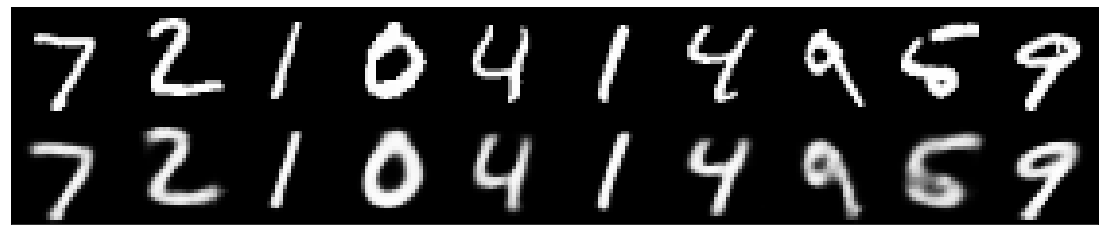

60000/60000 [==============================] - 46s 765us/sample - loss: 0.0702 - val_loss: 0.0675
Epoch 57/60
60000/60000 [==============================] - 46s 767us/sample - loss: 0.0702 - val_loss: 0.0673
Epoch 58/60
60000/60000 [==============================] - 46s 760us/sample - loss: 0.0702 - val_loss: 0.0674
Epoch 59/60
60000/60000 [==============================] - 46s 761us/sample - loss: 0.0701 - val_loss: 0.0675
Epoch 60/60
60000/60000 [==============================] - 46s 770us/sample - loss: 0.0702 - val_loss: 0.0676


In [ ]:
# Запуск обучения 
cvae.fit([x_train, y_train_cat, y_train_cat], x_train, shuffle=True, epochs=60,
         batch_size=batch_size,
         validation_data=([x_test, y_test_cat, y_test_cat], x_test),
         callbacks=[pltfig, tb],
         verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

## Результат обучения



In [ ]:
# Подаем 5 раз вектор [5,7,9,1], лейблы = 2,3,8,0,4

In [ ]:
def style_transfer(model, X, lbl_in, lbl_out): # объявляем функцию переноса стилей
    rows = X.shape[0] 
    if isinstance(lbl_in, int): # заполняем входные лейблы(энкодера)
        lbl = lbl_in 
        lbl_in = np.zeros((rows, 10)) # построчное заполнение нулями от 0 до 9
        lbl_in[:, lbl] = 1 # заполняем в нужную строчку единицу
    if isinstance(lbl_out, int): # заполняем выходные лейблы(декодера)
        lbl = lbl_out
        lbl_out = np.zeros((rows, 10)) # построчное заполнение нулями от 0 до 9
        lbl_out[:, lbl] = 1 # заполняем в нужную строчку единицу
    #print(lbl_in)
    #print(lbl_out)
    return model.predict([X, lbl_in, lbl_out]) # функция вернет предсказанные картинки

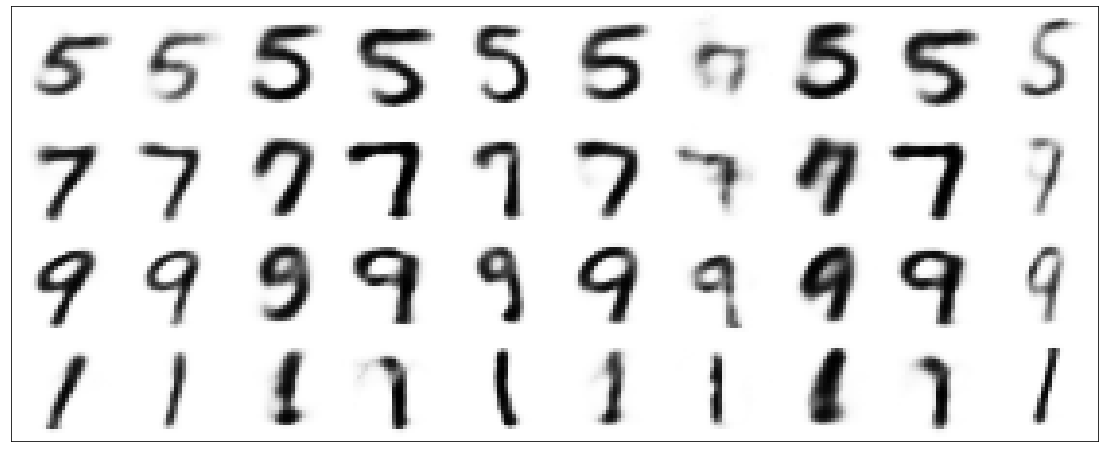

In [ ]:
n = 10 # количество картинок
lbl = 2 # выбираем лейбл
generated = [] # список сгенерированных картинок
prot = x_train[y_train == lbl][:n] # возьмем prot в качестве x с соответствующим выбранному значению лейбла 
my_vector=[5,7,9,1]
for i in my_vector: # идем по каждому классу
    generated.append(style_transfer(models["style_t"], prot, lbl, i)) # и генерим картинки с учетом переноса стиля

#generated[lbl] = prot
plot_digits(*generated, invert_colors=True) # отрисовываем картинки

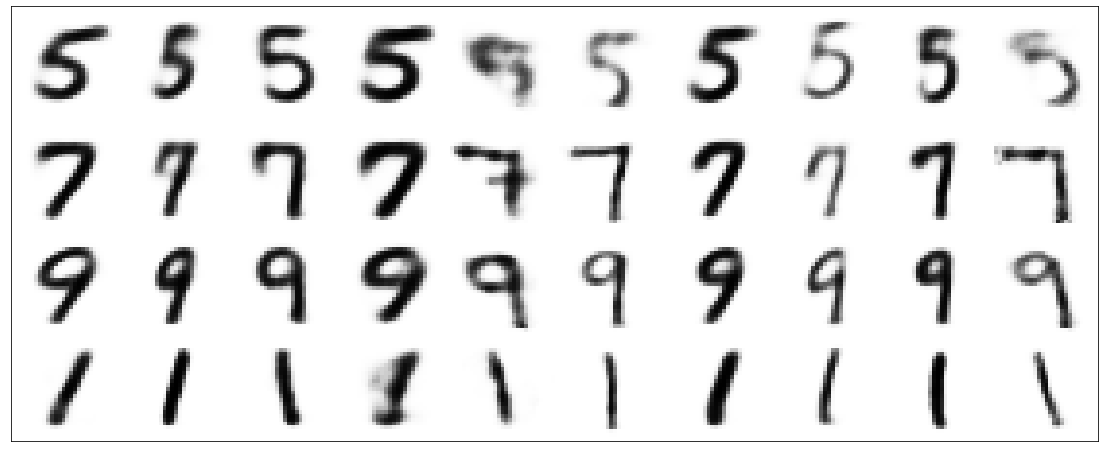

In [ ]:
n = 10 
lbl = 3 
generated = [] 
prot = x_train[y_train == lbl][:n] 
my_vector=[5,7,9,1]
for i in my_vector: 
    generated.append(style_transfer(models["style_t"], prot, lbl, i)) 

plot_digits(*generated, invert_colors=True) 

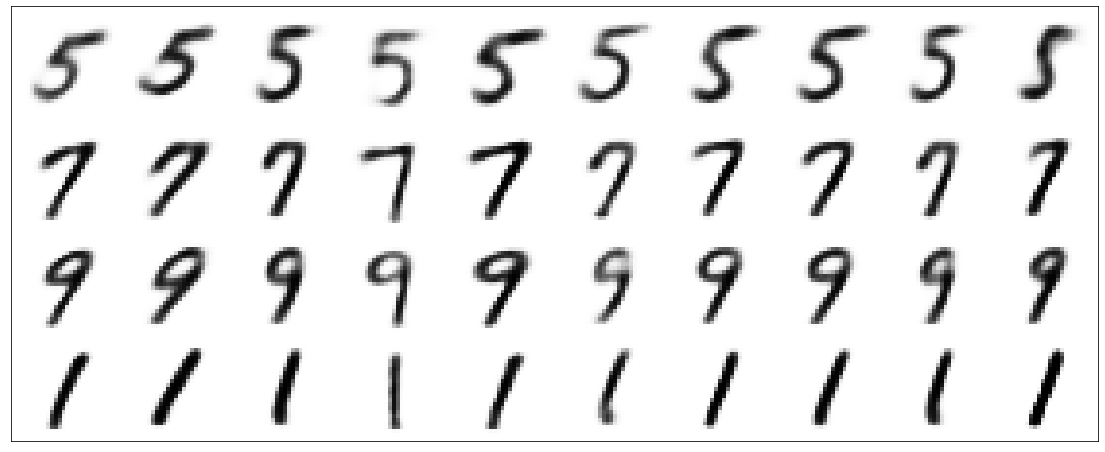

In [ ]:
n = 10 
lbl = 8 
generated = [] 
prot = x_train[y_train == lbl][:n] 
my_vector=[5,7,9,1]
for i in my_vector:
    generated.append(style_transfer(models["style_t"], prot, lbl, i))

plot_digits(*generated, invert_colors=True) 

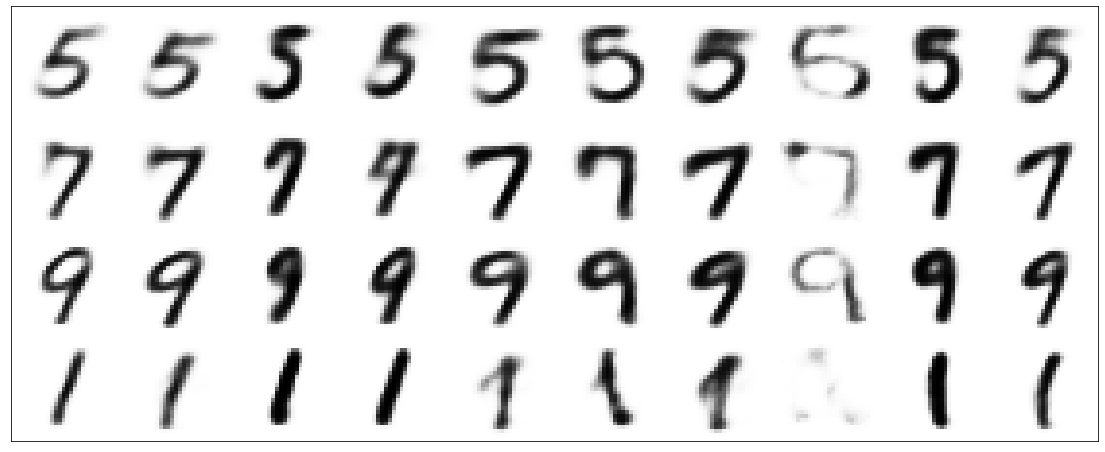

In [ ]:
n = 10 
lbl = 0 
generated = [] 
prot = x_train[y_train == lbl][:n] 
my_vector=[5,7,9,1]
for i in my_vector: 
    generated.append(style_transfer(models["style_t"], prot, lbl, i)) 

plot_digits(*generated, invert_colors=True) 

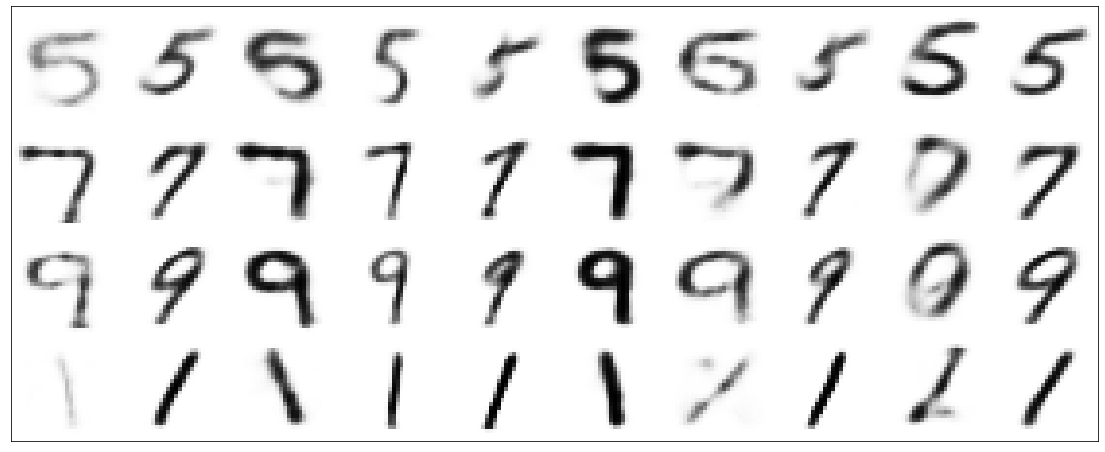

In [ ]:
n = 10 
lbl = 4 
generated = [] 
prot = x_train[y_train == lbl][:n] 
my_vector=[5,7,9,1]
for i in my_vector: 
    generated.append(style_transfer(models["style_t"], prot, lbl, i)) 

plot_digits(*generated, invert_colors=True)